In [319]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.morphology import white_tophat, black_tophat
from skimage.morphology import disk
from skimage import restoration
from scipy.signal import signaltools

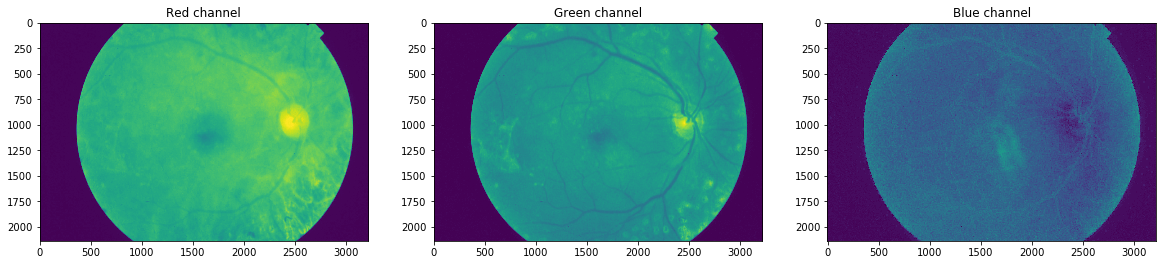

In [250]:
dataset_path = '../../Downloads/aptos2019-blindness-detection/'
train_imgs_path = os.path.join(dataset_path, 'train_images/')
original_img_path = os.listdir(dataset_path + train_imgs_path)[1]

original_img = cv2.imread(dataset_path + train_imgs_path + original_img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1, 3, 1)
plt.title('Red channel')
plt.imshow(original_img[:, :, 0])
fig.add_subplot(1, 3, 2)
plt.title('Green channel')
plt.imshow(original_img[:, :, 1])
fig.add_subplot(1, 3, 3)
plt.title('Blue channel')
plt.imshow(original_img[:, :, 2])

### Preprocessing

https://www.researchgate.net/publication/329565456_An_Efficient_Retinal_Blood_Vessel_Segmentation_using_Morphological_Operations

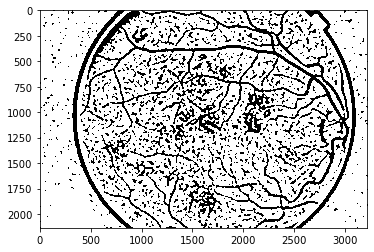

In [391]:
original_img_path = os.listdir(dataset_path + train_imgs_path)[0]

original_img = cv2.imread(dataset_path + train_imgs_path + original_img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# 1. Extract green channel
img_green = original_img[:, :, 1]

# 2. Use median 3x3 filter
img_median_filtered = cv2.medianBlur(img_green, 3)
# 3. Adaptive thresholding
img_thresholded_adaptive = \
    cv2.adaptiveThreshold(img_median_filtered, 127, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 97, 1)

# 4. Use contrast limited adaptive histogram equalisation
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(3, 3))
img_clahed = clahe.apply(img_thresholded_adaptive)

# 5. Denoising by median blur
img_denoised_blur = cv2.medianBlur(img_clahed, 21)
# 5. Denoising by Wiener filter
# psf = np.ones((5, 5)) / 25
# # img_clahed = cv2.filter2D(img_clahed, psf)
# img_denoised = np.uint8(restoration.wiener(img_clahed, psf, 200))

# 6. Otsu thresholding
ret2, img_otsu_thresholded = cv2.threshold(img_denoised_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 7. Suppress noise by using morphological opening by
#    circular SE with radius 8 px
kernel_circ = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
img_opened = cv2.morphologyEx(img_otsu_thresholded, cv2.MORPH_OPEN, kernel_circ)

# 8. Denoising by median blur
# img_denoised = cv2.medianBlur(img_opened, 21)

# kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
# img_denoised = cv2.morphologyEx(img_denoised, cv2.MORPH_OPEN, kernel_circ)

plt.imshow(img_opened, cmap=plt.cm.gray)

# 3.2 Dilate thresholded image by 3x3 kernel 50 times
# kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))
# img_thresholded_dilated = cv2.dilate(img_thresholded, kernel_rect, iterations=50)

# plt.imshow(img_opened, cmap=plt.cm.gray)

# 6. Use morphological Top-hat
# selem = disk(8)
# img_top_hat = white_tophat(img_opened, selem)

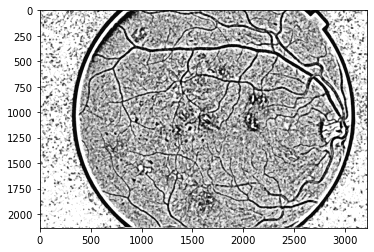

In [423]:
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

kernel = gaussian_kernel(15)

filtered_img = np.uint8(wiener_filter(img_clahed, kernel, K = 4))

# filtered_img = cv2.medianBlur(img_clahed, 21)

# 7. Suppress noise by using morphological opening by
#    circular SE with radius 8 px
kernel_circ = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
img_opened = cv2.morphologyEx(filtered_img, cv2.MORPH_OPEN, kernel_circ, iterations=2)

# 8. Denoising by median blur
jkj = cv2.medianBlur(img_opened, 15)

# kernel_cross = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
# img_denoised = cv2.morphologyEx(img_denoised, cv2.MORPH_OPEN, kernel_circ)

plt.imshow(jkj, cmap=plt.cm.gray)